<a href="https://colab.research.google.com/github/YoniTint/trust-ai-project/blob/main/trustuworth_ml_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Download data

In [ ]:
## CURRENTLY NOT TESTED YET SO DON'T USE!!
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
image_path = Path(r"/content/drive/MyDrive/Colab Notebooks/trustworthy_ml/data/data/celeba")

# If the image folder doesn't exist, download it and prepare it...
if not image_path.is_dir():
  print(f"{image_path} directory already exists... skipping download")
else:
  print(f"{image_path} does not exists, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

  # Unzip celeba data
  with zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/trustworthy_ml/data/data/archive (1).zip", "r") as zip_ref:
    print("Unzipping celeba data...")
    zip_ref.extractall(image_path)

##Loading libraries##

In [ ]:
!pip install grad-cam
!pip install ultralytics

## Import Libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import torch
import cv2
import numpy as np
import requests
import torchvision.transforms as transforms
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image
from PIL import Image
from google.colab.patches import cv2_imshow
from pathlib import Path
import os
import pandas as pd
from matplotlib import pyplot as plt

# Functions

In [ ]:
COLORS = np.random.uniform(0, 255, size=(80, 3))

def parse_detections(results):
    detections = results.pandas().xyxy[0]
    detections = detections.to_dict()
    boxes, colors, names = [], [], []

    for i in range(len(detections["xmin"])):
        confidence = detections["confidence"][i]
        if confidence < 0.2:
            continue
        xmin = int(detections["xmin"][i])
        ymin = int(detections["ymin"][i])
        xmax = int(detections["xmax"][i])
        ymax = int(detections["ymax"][i])
        name = detections["name"][i]
        category = int(detections["class"][i])
        color = COLORS[category]

        boxes.append((xmin, ymin, xmax, ymax))
        colors.append(color)
        names.append(name)
    return boxes, colors, names


def draw_detections(boxes, colors, names, img):
    for box, color, name in zip(boxes, colors, names):
        xmin, ymin, xmax, ymax = box
        cv2.rectangle(
            img,
            (xmin, ymin),
            (xmax, ymax),
            color,
            2)

        cv2.putText(img, name, (xmin, ymin - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                    lineType=cv2.LINE_AA)
    return img

def preprocess_image(image_url, is_local_image=True, index=1, metadata_df=None):
  if is_local_image:
    img = cv2.imread(image_url + '/' + metadata_df["image_id"].values[index])
  else:
    img = np.array(Image.open(requests.get(image_url, stream=True).raw))
  img = cv2.resize(img, (640, 640)) # YOLO expects exactly 640 shape to work
  rgb_img = img.copy()
  img = np.float32(img) / 255
  transform = transforms.ToTensor()
  image_as_tensor = transform(img).unsqueeze(0)

  return image_as_tensor, rgb_img, img

def load_model(model_path, model_name):
  model = torch.hub.load(model_path, model_name, pretrained=True)
  model.eval()
  model.cpu()
  # Yolo need the one before the last, change for other models?
  target_layers = [model.model.model.model[-2]]

  return model, target_layers

def add_bboxes_to_image(model, rgb_img):
  results = model([rgb_img])
  boxes, colors, names = parse_detections(results)
  detections = draw_detections(boxes, colors, names, rgb_img.copy())

  return detections

def activate_grad_cam_on_image(model, target_layers, image_as_tensor, img):
  # Flags work for now, if configuration needed, will be not hardcoded
  cam = EigenCAM(model, target_layers, use_cuda=False)
  grayscale_cam = cam(image_as_tensor)[0, :, :]
  cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)

  heatmap = cv2.applyColorMap(np.uint8(255 * grayscale_cam), colormap)
  heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

  return cam_image, heatmap

In [ ]:
# INIT COLORMAP VARIABLE
colormap = cv2.COLORMAP_JET

##Example on one image from the internet##

Using yolo5 model to detect a person

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-9-3 Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


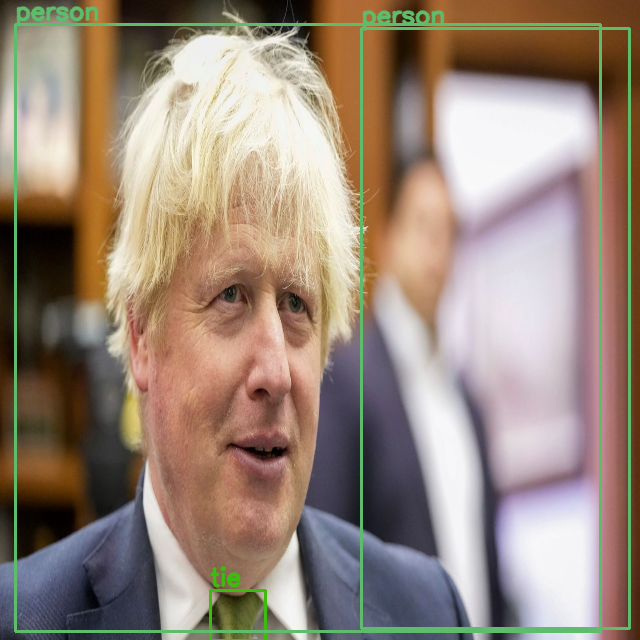

In [ ]:
IMAGE_URL = "https://e3.365dm.com/23/05/1600x900/skynews-boris-johnson-texas_6165501.jpg?20230524053259"

image_as_tensor, rgb_img, img = preprocess_image(IMAGE_URL, is_local_image=False)

model, target_layers = load_model('ultralytics/yolov5', 'yolov5s')

image_with_bboxes = add_bboxes_to_image(model, rgb_img)
Image.fromarray(image_with_bboxes)

Using grad-cam to create abstract shaped noise

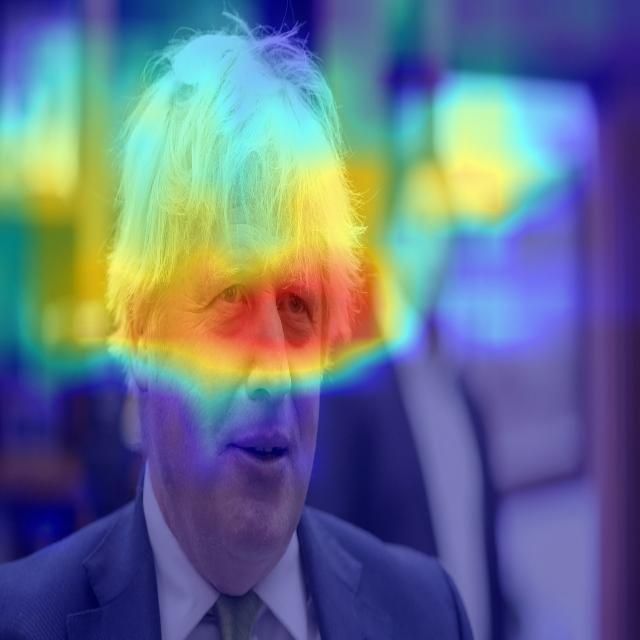

In [ ]:
grad_cam_activated_image, activated_image_heatmap = activate_grad_cam_on_image(model, target_layers, image_as_tensor, img)
Image.fromarray(grad_cam_activated_image)

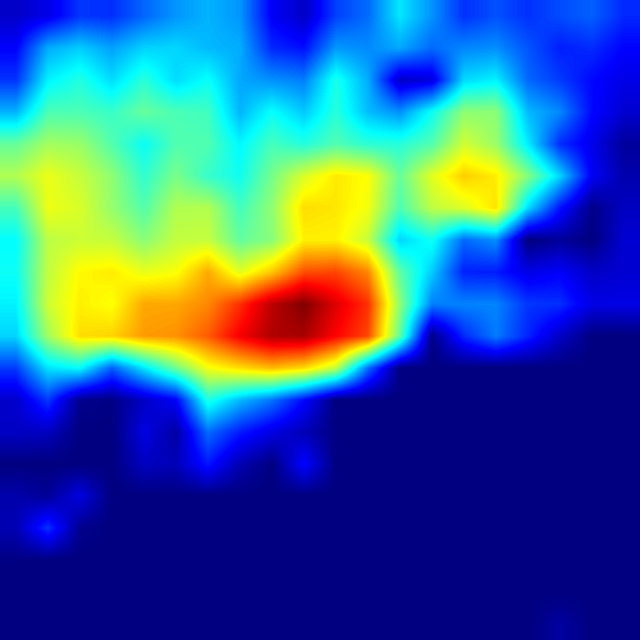

In [ ]:
Image.fromarray(activated_image_heatmap)

## PGD first iteration

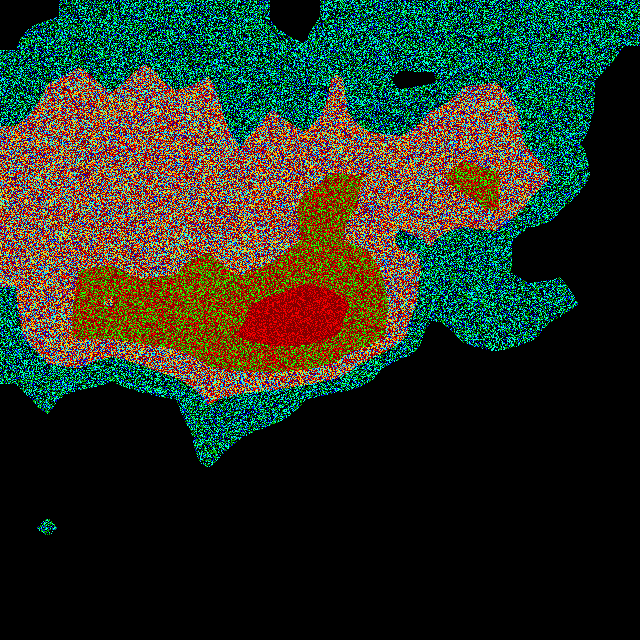

In [ ]:
eps = 1e-5
variance = 0.01
delta = torch.zeros(img.shape[0], img.shape[1], 3, dtype=torch.float64)
delta = delta + variance * torch.randn(img.shape[0], img.shape[1], 3)  * 255

# clip delta to be within [delta-eps, delta+eps]
delta = torch.clamp(delta, delta-eps, delta + eps)

# clip delta to be between 0 and 1
delta[np.where(activated_image_heatmap == 0)] = 0

delta_img = cv2.applyColorMap(np.uint8(delta), cv2.COLORMAP_JET)
delta_img[np.where(activated_image_heatmap == 0)] = 0
Image.fromarray(delta_img)

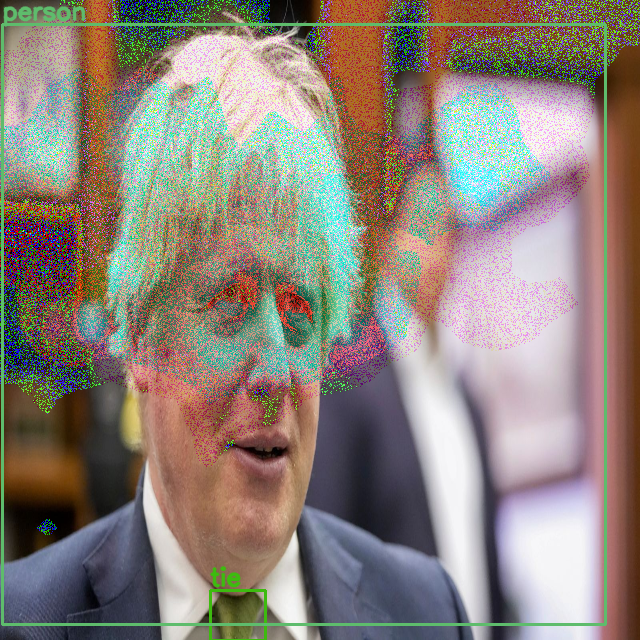

In [ ]:
img = np.array(Image.open(requests.get(IMAGE_URL, stream=True).raw))
img = cv2.resize(img, (640, 640))
rgb_img = img.copy()
noisy = rgb_img + delta_img

# give predictions on noisy image
results = model([noisy])
boxes, colors, names = parse_detections(results)
detections = draw_detections(boxes, colors, names, noisy.copy())
Image.fromarray(detections)

##Results on a dataset##
Now we'll try to get results for a full data set. this dataset is taken from: https://datasets.activeloop.ai/docs/ml/datasets/celeba-dataset/.

In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/trustworthy_ml/data

/content/drive/MyDrive/Colab Notebooks/trustworthy_ml/data


### Checking that dataset exists in the drive

In [ ]:
# How many images we will look on from the dataset
START_index = 0
END_index = 100


In [ ]:
BASIC_PATH = r"/content/drive/MyDrive/Colab Notebooks/trustworthy_ml/data/data/celeba"
FEATURE_PATH = os.path.join(BASIC_PATH,'list_attr_celeba.csv')
landmarks_PATH = os.path.join(BASIC_PATH,'list_landmarks_align_celeba.csv')
IMG_PATH = os.path.join(BASIC_PATH,'img_align_celeba/img_align_celeba')
pd.set_option('display.max_colwidth', None)

df = pd.read_csv(FEATURE_PATH, nrows=END_index)
landmarks_df = pd.read_csv(landmarks_PATH, nrows=END_index)


,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,...,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,000001.jpg,69,109,106,113,...,142,73,152,108,154
1,000002.jpg,69,110,107,112,...,135,70,151,108,153
2,000003.jpg,76,112,104,106,...,128,74,156,98,158
3,000004.jpg,72,113,108,108,...,138,71,155,101,151
4,000005.jpg,66,114,112,112,...,119,71,147,104,150


## Analyzing Facial Components for Successful Attack

In [ ]:
from google.colab.patches import cv2_imshow
import pickle
outputs_folder = r"/content/drive/MyDrive/Colab Notebooks/trustworthy_ml/data/data/celeba/img_align_celeba/img_align_celeba/outputs"

record = {
    'images_start_index': START_index,
    'image_end_index': END_index,
    'last_processed_image': 0,
    'has_finished': False,
    'count_attack_success': 0,
    'count_right_eye': 0,
    'count_left_eye': 0,
    'count_nose': 0,
    'count_mounth': 0
}



for index in range(START_index, END_index):
    record.update({'last_processed_image': index})

    image_as_tensor, rgb_img, img = preprocess_image(IMG_PATH, is_local_image=True, index=index, metadata_df=df)

    model, target_layers = load_model('ultralytics/yolov5', 'yolov5s')

    image_with_bboxes = add_bboxes_to_image(model, rgb_img)

    grad_cam_activated_image, activated_image_heatmap = activate_grad_cam_on_image(model, target_layers, image_as_tensor, img)

    delta = torch.zeros(img.shape[0], img.shape[1], 3, dtype=torch.float64)
    eps = 1e-5
    mean = 0
    sigma = 0.01
    noise = torch.tensor(np.random.normal(mean, sigma, (img.shape[0],img.shape[1],3))) * 255
    delta = torch.clamp(noise, noise-eps, noise + eps)

    delta[np.where(activated_image_heatmap == 0)] = 0
    delta_img = cv2.applyColorMap(np.uint8(delta), colormap)
    delta_img[np.where(activated_image_heatmap == 0)] = 0

    img = cv2.imread(IMG_PATH + '/' + df["image_id"].values[index])
    img = cv2.resize(img, (640, 640))
    rgb_img = img.copy()
    noisy = rgb_img + delta_img
    noisy = np.clip(noisy, 0, 255)

    # give predictions on noisy image
    results = model([noisy])
    boxes, colors, names = parse_detections(results)
    detections = draw_detections(boxes, colors, names, noisy.copy())
    Image.fromarray(detections)
    if (len(boxes) == 0) or (not 'person' in names):
      record.update({'count_attack_success': record.get('count_attack_success') + 1})
      righteye_x = landmarks_df["righteye_x"].values[index]
      righteye_y = landmarks_df["righteye_y"].values[index]
      if delta_img[righteye_x, righteye_y,0] != 0:
          record.update({'count_right_eye': record.get('count_right_eye') + 1})
          cv2.imwrite(f"{outputs_folder}/righteye_attack_img_{index}.png", detections)


      lefteye_x = landmarks_df["lefteye_x"].values[index]
      lefteye_y = landmarks_df["lefteye_y"].values[index]

      if delta_img[lefteye_x, lefteye_y,0] != 0:
          record.update({'count_left_eye': record.get('count_left_eye') + 1})
          cv2.imwrite(f"{outputs_folder}/lefteye_attack_img_{index}.png", detections)


      nose_x = landmarks_df["nose_x"].values[index]
      nose_y = landmarks_df["nose_y"].values[index]

      if delta_img[nose_x, nose_y,0] != 0:
        record.update({'count_nose': record.get('count_nose') + 1})
        cv2.imwrite(f"{outputs_folder}/nose_attack_img_{index}.png", detections)

      leftmouth_x = landmarks_df["leftmouth_x"].values[index]
      leftmouth_y = landmarks_df["leftmouth_y"].values[index]

      rightmouth_x = landmarks_df["rightmouth_x"].values[index]
      rightmouth_y = landmarks_df["rightmouth_y"].values[index]

      if delta_img[leftmouth_x, leftmouth_y,0] != 0 and delta_img[rightmouth_x, rightmouth_y,0] != 0:
          record.update({'count_mounth': record.get('count_mounth') + 1})
          cv2.imwrite(f"{outputs_folder}/mouth_attack_img_{index}.png", detections)

      # cv2.imwrite(f"{outputs_folder}/gaussian_img_{index}.png", detections)
      if index % 200 == 0:
          print(f'number of images so far: {index}')
          with open(f'{BASIC_PATH}/img_align_celeba/img_align_celeba/outputs/records/hila_records_10.pkl', 'wb') as f:
              pickle.dump(record, f)
record.update({'has_finished': True})
with open(f'{BASIC_PATH}/img_align_celeba/img_align_celeba/outputs/records/hila_records_10.pkl', 'wb') as f:
    pickle.dump(record, f)



Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-9-3 Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


number of images so far: 0


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-9-3 Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 
Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-9-3 Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 
Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-9-3 Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 
Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-9-3 Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 
Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-9-3 Python-3

In [ ]:
delta_img.shape

(640, 640, 3)

# This cell was adujsted multiple times for each file that represnts a set of images

In [ ]:
import pickle
# Load the list back from the pickle file.
with open(f'{BASIC_PATH}/img_align_celeba/img_align_celeba/outputs/records/hila_records_9.pkl', 'rb') as f:
    loaded_records = pickle.load(f)
loaded_records

{'images_start_index': 9400,
 'image_end_index': 10001,
 'last_processed_image': 10000,
 'has_finished': True,
 'count_attack_success': 324,
 'count_right_eye': 203,
 'count_left_eye': 226,
 'count_nose': 211,
 'count_mounth': 165}

# Calculating the results over all of the pickle files

In [ ]:
def calculate_total_values(folder_path, num_records, total_samples):
    total_counts = {
        'count_attack_success': 0,
        'count_right_eye': 0,
        'count_left_eye': 0,
        'count_nose': 0,
        'count_mouth': 0
    }

    for i in range(1, num_records):
        file_path = os.path.join(folder_path, f'hila_records_{i}.pkl')

        if os.path.exists(file_path):
            with open(file_path, 'rb') as f:
                record = pickle.load(f)
                total_counts['count_attack_success'] += record['count_attack_success']
                total_counts['count_right_eye'] += record['count_right_eye']
                total_counts['count_left_eye'] += record['count_left_eye']
                total_counts['count_nose'] += record['count_nose']
                total_counts['count_mouth'] += record['count_mounth']

    total_rates = {
        'attack_success_rate': total_counts['count_attack_success'] / total_samples,
        'right_eye_rate': total_counts['count_right_eye'] / total_counts['count_attack_success'],
        'left_eye_rate': total_counts['count_left_eye'] / total_counts['count_attack_success'],
        'nose_rate': total_counts['count_nose'] / total_counts['count_attack_success'],
        'mouth_rate': total_counts['count_mouth'] / total_counts['count_attack_success']
    }

    return total_rates
# Example usage:
folder_path = f'{BASIC_PATH}/img_align_celeba/img_align_celeba/outputs/records'
num_records = 10

total_counts = calculate_total_values(folder_path, num_records, total_samples=10000)
print(total_counts)

{'attack_success_rate': 0.4823, 'right_eye_rate': 0.660377358490566, 'left_eye_rate': 0.6993572465270579, 'nose_rate': 0.6547791830810699, 'mouth_rate': 0.5125440597138711}
